In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

# 自编码器

In [112]:
def add_noise(img,factor=0.5):
    noisy_img = img + factor*torch.randn_like(img)
    # 将图像噪声限值在[0，1]之间

    return torch.clamp(noisy_img,0,1)

In [113]:
# 导入数据
train_data = datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size = 64,shuffle=True)
test_loader = DataLoader(test_data,batch_size = 64,shuffle=False)

In [114]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,stride=2,padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding = 1),
            nn.ReLU()
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size = 3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,kernel_size = 3,stride = 2,padding=1,output_padding=1),
            nn.Sigmoid()
            )
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [115]:
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())


for epoch in range(epochs):
    model.train()
    train_loss = 0
    for img,_ in train_loader:
        img = img.to(device)
        noise_img = add_noise(img)

        # 前向传播
        output = model(noise_img)
        # 计算损失
        loss = criterion(output,img)
        # 梯度清零
        model.zero_grad()
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()

        # 梯度累计
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    test_loss =0
    with torch.no_grad():
        for img,_ in test_loader:
            img = img.to(device)
            noise_img = add_noise(img)

            # 前向传播
            output = model(noise_img)
            # 计算损失
            loss = criterion(output,img)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f'{epoch+1}/{epochs}',
          f'train_loss = {train_loss}',
          f'test_loss = {test_loss}')

1/10 train_loss = 0.02874202663495914 test_loss = 0.014560435803690154
2/10 train_loss = 0.014239826860196238 test_loss = 0.013770542884613298
3/10 train_loss = 0.013691097565455985 test_loss = 0.013377721184140937
4/10 train_loss = 0.013360548326606625 test_loss = 0.01304973251998994
5/10 train_loss = 0.013084359272424854 test_loss = 0.012905628515324395
6/10 train_loss = 0.012936952292545836 test_loss = 0.012748245102394917
7/10 train_loss = 0.012793258708248387 test_loss = 0.01248669970756883
8/10 train_loss = 0.012684710518415295 test_loss = 0.01254914206850111
9/10 train_loss = 0.012585014559582733 test_loss = 0.012436830652225169
10/10 train_loss = 0.012509110580279884 test_loss = 0.012338914617801167


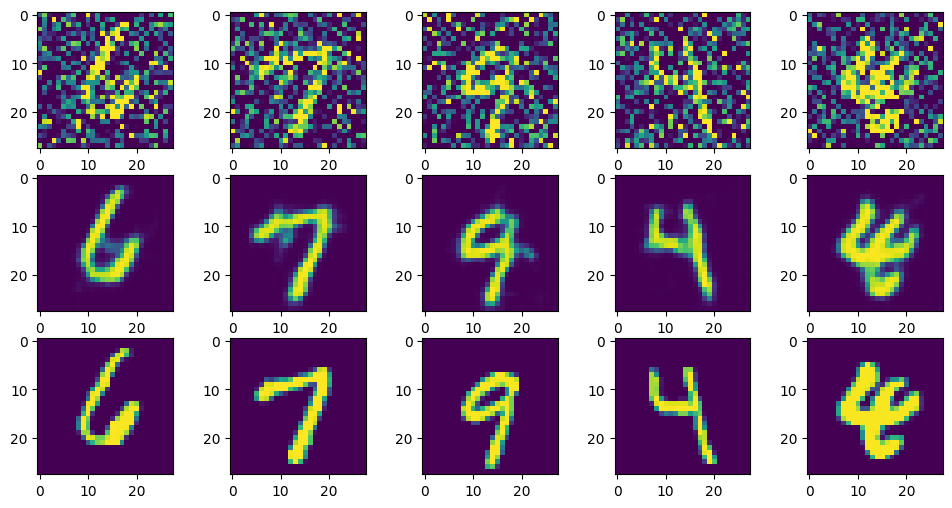

In [116]:
test_loader = DataLoader(test_data, batch_size=5, shuffle=True)
model.eval()
with torch.no_grad():
    # 获取一个批次的数据。
    test_batch = next(iter(test_loader))
    imgs, _ = test_batch
    imgs = imgs.to(device)
    noisy_imgs = add_noise(imgs)
    reconstructed = model(noisy_imgs)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i in range(5):
   axes[0, i].imshow(noisy_imgs[i].squeeze().cpu())
   axes[1, i].imshow(reconstructed[i].squeeze().cpu())
   axes[2, i].imshow(imgs[i].squeeze().cpu())

In [117]:
torch.save(model.state_dict(),'.\model\Encode-Dcoder_reduce_nosie.pth')